In [87]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy import sparse
from multiprocessing import Pool, cpu_count# used for multiprocessing
from sklearn.metrics.pairwise import cosine_similarity
import time
import rec_utils #featurize data
import gc
from collections import OrderedDict

import xgboost as xgb
import random
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# 4. Machine Learning Models

* As the size of the data is huge, we sample a small subset of data at random and build models on it.

## 4.1 Sampling data

In [2]:
def sample_sparse_matrix(sparse_matrix, num_users, num_movies, save_name):
    
    #retrieve the info of sparse matrix
    row_idxs, col_idxs, ratings = sparse.find(sparse_matrix)
    
    #retrieve the unique users and movies
    users = np.unique(row_idxs)
    movies = np.unique(col_idxs)
    
    print(f"Sparse Matrix : (users, movies)     ==> ({len(users)}, {len(movies)})")
    print(f"Number of ratings in Sparse Matrix  ==>  {len(ratings)}\n")
    
    np.random.seed(15)
    sampled_users = np.random.choice(users, num_users)
    sampled_movies = np.random.choice(movies, num_movies)
    
    #boolean mask for sampled users and sampled_movies
    mask = np.logical_and(np.isin(row_idxs, sampled_users), np.isin(col_idxs, sampled_movies))
    
    print("Sampling the matrix....\n")
    #retrieve the sampled ratings
    sampled_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_idxs[mask], col_idxs[mask])),
                                              shape=(max(sampled_users)+1, max(sampled_movies)+1))
    
    print(f"Sampled Sparse Matrix : (users, movies)     ==> ({len(sampled_users)}, {len(sampled_movies)})")
    print(f"Number of ratings in Sampled Sparse Matrix  ==>  {ratings[mask].shape[0]}\n")
    
    print('Saving to disk...\n')
    sparse.save_npz(save_name, sampled_sparse_matrix)
    print("Done...\n")
    
    return sampled_sparse_matrix

__LOADING THE TRAIN, CV and TEST SPARSE MATRICES__

In [3]:
train_sparse_matrix = sparse.load_npz('train_sparse_matrix.npz')
cv_sparse_matrix = sparse.load_npz('cv_sparse_matrix.npz')
test_sparse_matrix = sparse.load_npz('test_sparse_matrix.npz')

print(f"shape of train : {train_sparse_matrix.get_shape()}")
print(f"shape of cv    : {cv_sparse_matrix.get_shape()}")
print(f"shape of test  : {test_sparse_matrix.get_shape()}")

shape of train : (2649430, 17771)
shape of cv    : (2649430, 17771)
shape of test  : (2649430, 17771)


<h3>4.1.1 Build samples</h3>

__SAMPLE FROM TRAIN__

In [4]:
start = datetime.now()
if not os.path.isfile('sampled_train_matrix.npz'):
    sampled_train_matrix = sample_sparse_matrix(train_sparse_matrix,
                                                num_users=25000, num_movies=3000,
                                                save_name='sampled_train_matrix.npz')
else: 
    print('Loading from disk...\n')
    sampled_train_matrix = sparse.load_npz('sampled_train_matrix.npz')
    print('Done...\n')

print(f"Processed in {datetime.now() - start}")

Loading from disk...

Done...

Processed in 0:00:00.158805


__SAMPLE FROM CV__

In [5]:
start = datetime.now()
if not os.path.isfile('sampled_cv_matrix.npz'):
    sampled_cv_matrix = sample_sparse_matrix(cv_sparse_matrix,
                                             num_users=7000, num_movies=1400,
                                             save_name='sampled_cv_matrix.npz')
else: 
    print('Loading from disk...\n')
    sampled_cv_matrix = sparse.load_npz('sampled_cv_matrix.npz')
    print('Done...\n')

print(f"Processed in {datetime.now() - start}")

Loading from disk...

Done...

Processed in 0:00:00.028905


__SAMPLE FROM TEST__

In [6]:
start = datetime.now()
if not os.path.isfile('sampled_test_matrix.npz'):
    sampled_test_matrix = sample_sparse_matrix(test_sparse_matrix,
                                               num_users=7000, num_movies=1400,
                                               save_name='sampled_test_matrix.npz')
else: 
    print('Loading from disk...\n')
    sampled_test_matrix = sparse.load_npz('sampled_test_matrix.npz')
    print('Done...\n')

print(f"Processed in {datetime.now() - start}")

Loading from disk...

Done...

Processed in 0:00:00.066828


<h2>4.2 Finding Averages (from sampled train)</h2>

In [7]:
def get_avg_ratings(sparse_matrix, of='user'):
    
    # if users avg over rows, else cols
    ax = 1 if of == 'user' else 0
    sum_ratings = sparse_matrix.sum(axis=ax).A1
    num_ratings = (sparse_matrix != 0).sum(axis=ax).A1
    
    #avg
    u, m = sparse_matrix.shape
    avg_ratings = {i : np.round(sum_ratings[i] / num_ratings[i], 4) 
            for i in range(u if ax==1 else m) 
            if num_ratings[i] != 0}
    
    
    return avg_ratings

__GLOBAL AVERAGE OF ALL MOVIE RATINGS__

In [8]:
sampled_train_averages = {}
global_avg = sampled_train_matrix.sum() / sampled_train_matrix.count_nonzero()
sampled_train_averages['global'] = global_avg
print(f"Global average of all movie ratings in train : { global_avg : .3f}")

Global average of all movie ratings in train :  3.577


__AVERAGE RATING OF USER__

In [9]:
sampled_train_averages['user'] = get_avg_ratings(sampled_train_matrix, 'user')
print(f"average rating given by user 142 : {sampled_train_averages['user'][142]}")

average rating given by user 142 : 3.5


__AVERAGE RATING OF MOVIE__

In [10]:
sampled_train_averages['movie'] = get_avg_ratings(sampled_train_matrix, 'movie')
print(f"average rating of movie 47 : {sampled_train_averages['movie'][47]}")

average rating of movie 47 : 3.3738


## 4.3 Featurizing data

In [11]:
print(f"Number of ratings in sampled train matrix : {sampled_train_matrix.count_nonzero()}")
print(f"Number of ratings in sampled cv matrix    : {sampled_cv_matrix.count_nonzero()}")
print(f"Number of ratings in sampled test matrix  : {sampled_test_matrix.count_nonzero()}")

Number of ratings in sampled train matrix : 762801
Number of ratings in sampled cv matrix    : 34725
Number of ratings in sampled test matrix  : 30999


<h3> 4.3.1 Featurizing data for regression problem </h3>

<h4> 4.3.1 Featurizing train data </h4>

-----------

- __GAvg__ : Average rating of all the ratings 

- __Similar users rating of this movie__:<br>
sur1, sur2, sur3 (ratings of top 3 similar users who rated that movie)

- __Similar movies rated by this user__:<br>
smr1, smr2, smr3 (ratings of top 3 similar movies rated by this user)

- __UAvg__ : Average rating of a user.

- __MAvg__ : Average rating of this movie.

- __rating__ : Rating of this movie by this user.

-----------------------

In [12]:
columns = ['user', 'movie', 'GAvg', 'sur1', 'sur2', 'sur3', 'sur4', 'sur5','smr1', 'smr2', 'smr3', 'smr4', 'smr5', 'UAvg', 'MAvg', 'rating']

In [13]:
def featurize_data(idx, user, movie, rating, sparse_matrix, avgs_dict):
    
    sampled_train_averages = avgs_dict
    #------------------ratings of movie by similar users for "current user"-------------------
    top_sim_users = cosine_similarity(sparse_matrix[user], sparse_matrix).ravel().argsort()[::-1]
    top_sim_user_ratings = sparse_matrix[top_sim_users, movie].toarray().ravel()
    top_sim_user_ratings = top_sim_user_ratings[top_sim_user_ratings != 0][:5].tolist()
    top_sim_user_ratings += [sampled_train_averages['movie'][movie]]*(5 - len(top_sim_user_ratings))
    #print(user)
        
    #------------------ratings of user to similar movies of 'cuurent movie'---------------------
    top_sim_movies = cosine_similarity(sparse_matrix[:, movie].T, sparse_matrix.T).ravel().argsort()[::-1]
    top_sim_movie_ratings = sparse_matrix[user, top_sim_movies].toarray().ravel()
    top_sim_movie_ratings = top_sim_movie_ratings[top_sim_movie_ratings != 0][:5].tolist()
    top_sim_movie_ratings += [sampled_train_averages['user'][user]]*(5 - len(top_sim_movie_ratings))
    #print(movie)
        
    #------------------build a list using the above features-----------------------------
        
    vector = list()
    vector.append(user)
    vector.append(movie)
    vector.append(sampled_train_averages['global'])
    vector += top_sim_user_ratings
    vector += top_sim_movie_ratings
    vector.append(sampled_train_averages['user'][user])
    vector.append(sampled_train_averages['movie'][movie])
    vector.append(rating)
        
    return (idx, vector)

<font color='orange'>__MULTIPROCESSING__</font>

* The sheer amount of data we've makes us run into processing problems.
* Python by default has Global Interpreter Lock(is only single threaded), <br>
Featurizing the data consumes a lot of time(~5 days).
* Thankfully Python has an inbuilt multiprocessing library to make use of all the cores, <br>
the compute time is reduced by half(~2days).
* Below is a comparision of the two.

In [14]:
t1 = datetime.now()

sample_results = []
sampled_users, sampled_movies, sampled_ratings = sparse.find(sampled_train_matrix)
for idx, (user, movie, rating) in enumerate(zip(sampled_users[:100],
                                                        sampled_movies[:100],
                                                        sampled_ratings[:100])):
    sample_results.append(featurize_data(idx, user, movie, rating, sampled_train_matrix, sampled_train_averages))

print(f"\n ==> Processed using SINGLE CORE in {datetime.now() - t1}")


 ==> Processed using SINGLE CORE in 0:00:44.494594


In [15]:
t1 = datetime.now()

sample_results = []
pool = Pool(cpu_count())

sampled_users, sampled_movies, sampled_ratings = sparse.find(sampled_train_matrix)
for idx, (user, movie, rating) in enumerate(zip(sampled_users[:100],
                                                        sampled_movies[:100],
                                                        sampled_ratings[:100])):
    pool. apply_async(rec_utils.featurize_data,
                     args=(idx, user, movie, rating, sampled_train_matrix, sampled_train_averages),
                     callback=sample_results.append)
pool.close()
pool.join()

print(f"\n ==> Processed using MULTIPLE CORES in {datetime.now() - t1}")


 ==> Processed using MULTIPLE CORES in 0:00:23.522916


__FEATURIZING TRAIN DATA__

* Be patient as the computution is time consuming with many function calls per thread.
* *(The below computation took 2days)*

In [14]:
if not os.path.isfile('train_features_matrix.csv'):
    sampled_users, sampled_movies, sampled_ratings = sparse.find(sampled_train_matrix)
    print(f"\n Number of sampled ratings to be processed in TRAIN : {len(sampled_ratings)}")

    train_results_dict = OrderedDict()
    bs = 624
    num_batches = int(len(sampled_ratings) / bs) + 1
    print(f"\n Splitting into {num_batches} batches each of size {bs}\n\n")

    for b in range(num_batches):
    
        t1 = datetime.now()
    
        train_results = []
        pool = Pool(cpu_count())
    
        for idx, (user, movie, rating) in enumerate(zip(sampled_users[b*bs : (b+1)*bs],
                                                        sampled_movies[b*bs : (b+1)*bs],
                                                        sampled_ratings[b*bs : (b+1)*bs])):
            pool.apply_async(rec_utils.featurize_data,
                             args=(idx, user, movie, rating, sampled_train_matrix, sampled_train_averages),
                             callback=train_results.append)
   
        pool.close()
        pool.join()
    
        train_results.sort(key=lambda x : x[0])
        train_results = [r for _, r in train_results]
        
        train_results_dict[b] = train_results
    
        print(f"\n ==> Processed batch{b+1} in {datetime.now() - t1}")
    
    df = pd.DataFrame(np.concatenate([train_results_dict[key] for key in train_results_dict.keys()], 0), columns=columns)
    df.to_csv('train_features_matrix.csv', index=False)
    
else:
    
    print('\n Loading from disk...')
    train_features_matrix = pd.read_csv('train_features_matrix.csv')
    print('\n Done..')


 Loading from disk...

 Done..


__FEATURIZING CV DATA__

In [15]:
sampled_cv_averages = {}
sampled_cv_averages['global'] = np.round(sampled_cv_matrix.sum() / sampled_cv_matrix.count_nonzero(), 4)
sampled_cv_averages['user'] = get_avg_ratings(sampled_cv_matrix, 'user')
sampled_cv_averages['movie'] = get_avg_ratings(sampled_cv_matrix, 'movie')

In [16]:
if not os.path.isfile('cv_features_matrix.csv'):
    
    t1 = datetime.now()

    sampled_users, sampled_movies, sampled_ratings = sparse.find(sampled_cv_matrix)
    print(f"Number of sampled ratings to be processed in Cross_Val : {len(sampled_ratings)}\n")

    cv_results = []
    def collect_result(result):
        global cv_results
        cv_results.append(result)
    
    pool = Pool(cpu_count())

    for idx, (user, movie, rating) in enumerate(zip(sampled_users,
                                                sampled_movies,
                                                sampled_ratings)):
    
        pool.apply_async(rec_utils.featurize_data,
                         args=(idx, user, movie, rating, sampled_cv_matrix, sampled_cv_averages),
                         callback=collect_result)
   
    pool.close()
    pool.join()

    cv_results.sort(key=lambda x : x[0])
    cv_results = [r for _, r in cv_results]
    pd.DataFrame(cv_results, columns=columns).to_csv('cv_features_matrix.csv', index=False)
    
    del cv_results
    gc.collect()

    print(f"\nprocessed in {datetime.now() - t1}sec")
    
else:
    print('\n Loading from disk...')
    cv_features_matrix = pd.read_csv('cv_features_matrix.csv')
    print('\n Done..')


 Loading from disk...

 Done..


__FEATURIZING TEST DATA__

In [17]:
sampled_test_averages = {}
sampled_test_averages['global'] = np.round(sampled_test_matrix.sum() / sampled_test_matrix.count_nonzero(), 4)
sampled_test_averages['user'] = get_avg_ratings(sampled_test_matrix, 'user')
sampled_test_averages['movie'] = get_avg_ratings(sampled_test_matrix, 'movie')

In [18]:
if not os.path.isfile('test_features_matrix.csv'):
    sampled_users, sampled_movies, sampled_ratings = sparse.find(sampled_test_matrix)
    print(f"\n Number of sampled ratings to be processed in Cross_Val : {len(sampled_ratings)}\n")

    test_results_dict = OrderedDict()
    bs = 620
    num_batches = int(len(sampled_ratings) / bs) + 1
    print(f"\n Splitting into {num_batches} batches each of size {bs}")

    for b in range(num_batches):
    
        t1 = datetime.now()
    
        test_results = []
        pool = Pool(cpu_count())
    
        for idx, (user, movie, rating) in enumerate(zip(sampled_users[b*bs : (b+1)*bs],
                                                    sampled_movies[b*bs : (b+1)*bs],
                                                    sampled_ratings[b*bs : (b+1)*bs])):
            pool.apply_async(rec_utils.featurize_data,
                             args=(idx, user, movie, rating, sampled_test_matrix, sampled_test_averages),
                             callback=test_results.append)
   
        pool.close()
        pool.join()
    
        test_results.sort(key=lambda x : x[0])
        test_results = [r for _, r in test_results]
    
        test_results_dict[b] = test_results
    
        print(f"\n ==> Processed batch{b+1} in {datetime.now() - t1}")


    df = pd.DataFrame(np.concatenate([test_results_dict[key] for key in test_results_dict.keys()], 0), columns=columns)
    df.to_csv('test_features_matrix.csv', index=False)
    
else:
    print("\n Loading from disk...")
    test_features_matrix = pd.read_csv('test_features_matrix.csv')
    print('\n Done...')


 Loading from disk...

 Done...


<h2> 4.4 Transforming data for Surprise models</h2>

__TRANSFORMING TRAIN DATA__

* We can't just input raw data (movie, user, rating) to train the models using the Surprise library.

* The Surprise Library has a seperate format for TRAIN and TEST data, which will be useful for training the models <br>like SVD, KNNBaseLineOnly....etc..,in Surprise.

* We can load the data from a file, or from a Pandas  DataFrame. [load_from_dataframe](http://surprise.readthedocs.io/en/stable/getting_started.html#load-dom-dataframe-py) 

In [19]:
from surprise import Reader, Dataset

In [20]:
# It is to specify how to read the dataframe.
# for our dataframe, we don't have to specify anything extra..
reader = Reader(rating_scale=(1, 5))

# create the traindata from the dataframe...
train_data = Dataset.load_from_df(train_features_matrix[['user', 'movie', 'rating']], reader)

# build the trainset from traindata.., It is of dataset format from surprise library..
Xtrain = train_data.build_full_trainset() 

__TRANSFORMING CV and TEST DATA__

- The CV and Test Sets are just a list of (user, movie, rating) tuples. (Order in the tuple is important) 

In [21]:
Xcv = list(zip(cv_features_matrix.user.values,
               cv_features_matrix.movie.values,
               cv_features_matrix.rating.values))

Xtest = list(zip(test_features_matrix.user.values,
                 test_features_matrix.movie.values,
                 test_features_matrix.rating.values))


<h2> 4.5 Applying Machine Learning models </h2>

* We'll use a Dictionary to store the RMSE and MAPE of all the models trained.


* It stores the metrics in a dictionary of dictionaries

>  __keys__ : model_name <br> __value__   : dict( __key__ : metric, __value__ : error_value )


In [22]:
models_evaluation_train = {}
models_evaluation_cv = {}
models_evaluation_test = {}

__UTILITY FUNCTIONS FOR REGRESSION__

In [23]:
# to get rmse and mape given actual and predicted ratings..
def get_error_metrics(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    mape = np.mean(np.abs( (y_true - y_pred)/y_true )) * 100
    return rmse, mape


def run_xgbr(Xtrain, Ytrain, Xtest, Ytest, max_depth=None, n_trees=None):
    
    print('\n Training the Model....')
    start = datetime.now()
    xgb_reg = xgb.XGBRegressor(n_jobs=-2, random_state=15, max_depth=max_depth, n_estimators=n_trees)
    xgb_reg.fit(Xtrain, Ytrain, eval_metric = 'rmse')
    print(f'\n Done... Time taken : {datetime.now() - start}')
    
    Ytrain_pred = xgb_reg.predict(Xtrain)
    rmse_train, mape_train = get_error_metrics(Ytrain, Ytrain_pred)
    
    print('\n', '-'*45)
    print('    ERROR ON TRAIN DATA ')
    print('-'*45)
    print(f'==> RMSE : {rmse_train}')
    print(f'==> MAPE : {mape_train}')
    
    Ytest_pred = xgb_reg.predict(Xtest)
    rmse_test, mape_test = get_error_metrics(Ytest, Ytest_pred)
    
    test_results = {'rmse': rmse_test,
                     'mape' : mape_test,
                     'predictions' : Ytest_pred}
    
    print('\n', '-'*45)
    print('    ERROR ON TEST DATA')
    print('-'*45)
    print(f'==> RMSE : {rmse_test}')
    print(f'==> MAPE : {mape_test}')
    print('\n', '-'*45)
    
    xgb.plot_importance(xgb_reg)
    
    return test_results
    
    

#'''
def xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=None, n_trees=None):
    
    rmse_errors = np.zeros((len(n_trees), len(depth_vals)))
    mape_errors = rmse_errors.copy()
    
    for i, n_t in enumerate(n_trees):
        #print(f"At n_trees = {n_t}")
        for j, depth in enumerate(depth_vals):
            algo = xgb.XGBRegressor(n_jobs=-1, max_depth=depth, random_state=15, n_estimators=n_t)
            algo.fit(x_train, y_train, eval_metric = 'rmse')
            #y_train_pred = algo.predict(x_train)
            #rmse_train, mape_train = get_error_metrics(y_train.values, y_train_pred)
            y_cv_pred = algo.predict(x_cv) 
            rmse_cv, mape_cv = get_error_metrics(y_true=y_cv.values, y_pred=y_cv_pred)
            rmse_errors[i, j] = np.round(rmse_cv, 5)
            mape_errors[i, j] = np.round(mape_cv, 5)
            #print(f"            depth = {depth}, rmse = {rmse_cv : .5f}, mape = {mape_cv : .5f}")
            
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(12, 5))
    fig.suptitle("RMSE and MAPE")
    
    min_rmse = rmse_errors.min()
    best_n_trees = n_trees[np.where(rmse_errors == min_rmse)[0][0]]
    best_depth = depth_vals[np.where(rmse_errors == min_rmse)[1][0]]
    
    sns.heatmap(rmse_errors,
                fmt='.4f',
                ax=ax1,
                xticklabels=depth_vals,
                yticklabels=n_trees,
                annot=True,
                linewidths=0.8)
    ax1.set_xlabel('max_depth')
    ax1.set_ylabel('n_trees')
    ax1.set_title(f'best RMSE={min_rmse} at n_trees={best_n_trees}, depth={best_depth}')
    
    sns.heatmap(mape_errors,
                fmt='.4f',
                ax=ax2,
                xticklabels=depth_vals,
                yticklabels=n_trees,
                annot=True,
                linewidths=0.5)
    
    ax2.set_xlabel('max_depth')
    ax2.set_ylabel('n_trees')
    ax2.set_title('MAPE')

__UTILITY FUNCTIONS FOR SURPRISE__

In [24]:
# it is just to makesure that all of our algorithms should produce same results
# everytime they run...
import random
random.seed(15)
np.random.seed(15)

##########################################################
# get  (actual_list , predicted_list) ratings given list 
# of predictions (prediction is a class in Surprise).    
##########################################################
def get_ratings(predictions):
    actual = np.array([pred.r_ui for pred in predictions])
    pred = np.array([pred.est for pred in predictions])
    
    return actual, pred

################################################################
# get ''rmse'' and ''mape'' , given list of prediction objecs 
################################################################
def get_errors(predictions):

    actual, pred = get_ratings(predictions)
    rmse = np.sqrt(np.mean((pred - actual)**2))
    mape = np.mean(np.abs(pred - actual)/actual)

    return rmse, mape*100

##################################################################################
# It will return predicted ratings, rmse and mape of both train and test data   #
##################################################################################
def run_surprise(algo, trainset, testset, cvset=None): 
    '''
        return train_dict, test_dict
    
        It returns two dictionaries, one for train and the other is for test
        Each of them have 3 key-value pairs, which specify ''rmse'', ''mape'', and ''predicted ratings''.
    '''
    
    train_results = dict()
    test_results = dict()
    cv_results = dict() if cvset is not None else None
    
    # train the algorithm with the trainset
    start = datetime.now()
    print('\n Training the MODEL...')
    algo.fit(trainset)
    print(f'\n Done... Time taken : {datetime.now() - start}')
    
    # ---------------- Evaluating train data--------------------#
    st = datetime.now()
    #print('\n Evaluating the MODEL with TRAIN data..')
    # get the train predictions (list of prediction class inside Surprise)
    train_preds = algo.test(trainset.build_testset())
    # get predicted ratings from the train predictions..
    train_actual_ratings, train_pred_ratings = get_ratings(train_preds)
    # get ''rmse'' and ''mape'' from the train predictions.
    train_rmse, train_mape = get_errors(train_preds)
    #print('time taken : {}'.format(datetime.now()-st))
    
    print("\n", '-'*45)
    print('    ERROR ON TRAIN DATA')
    print('-'*45)
    print(f"==> RMSE : {train_rmse}\n==> MAPE : {train_mape}\n")
    
    train_results['rmse'] = train_rmse
    train_results['mape'] = train_mape
    train_results['predictions'] = train_pred_ratings
    
    
    #------------ Evaluating Test data---------------#
    #print('\n Evaluating for TEST data...')
    # get the predictions( list of prediction classes) of test data
    test_preds = algo.test(testset)
    # get the predicted ratings from the list of predictions
    test_actual_ratings, test_pred_ratings = get_ratings(test_preds)
    # get error metrics from the predicted and actual ratings
    test_rmse, test_mape = get_errors(test_preds)
    #print('time taken : {}'.format(datetime.now()-st))
    
    print("\n", '-'*45)
    print('    ERROR ON TEST DATA')
    print('-'*45)
    print(f"==> RMSE : {test_rmse}\n==> MAPE : {test_mape}\n")
    
    print('\n', '-'*45)
    # store them in test dictionary
    test_results['rmse'] = test_rmse
    test_results['mape'] = test_mape
    test_results['predictions'] = test_pred_ratings
    
    if cvset is not None:
        cv_preds = algo.test(cvset)
        cv_actual_ratings, cv_pred_ratings = get_ratings(cv_preds)
        cv_rmse, cv_mape = get_errors(cv_preds)
        
        cv_results['rmse'] = cv_rmse
        cv_results['mape'] = cv_mape
        cv_results['predictions'] = cv_pred_ratings
        
        return train_results, test_results, cv_results
    
    
    #print('Total time taken to run this algorithm :', datetime.now() - start)
    
    return train_results, test_results

<h3> 4.4.1 XGBoost with initial 13 features </h3>

In [25]:
# prepare Train data
x_train = train_features_matrix.drop(['user','movie','rating'], axis=1)
y_train = train_features_matrix['rating']

# Prepare Test data
x_cv = cv_features_matrix.drop(['user','movie','rating'], axis=1)
y_cv = cv_features_matrix['rating']

# Prepare Test data
x_test = test_features_matrix.drop(['user','movie','rating'], axis=1)
y_test = test_features_matrix['rating']

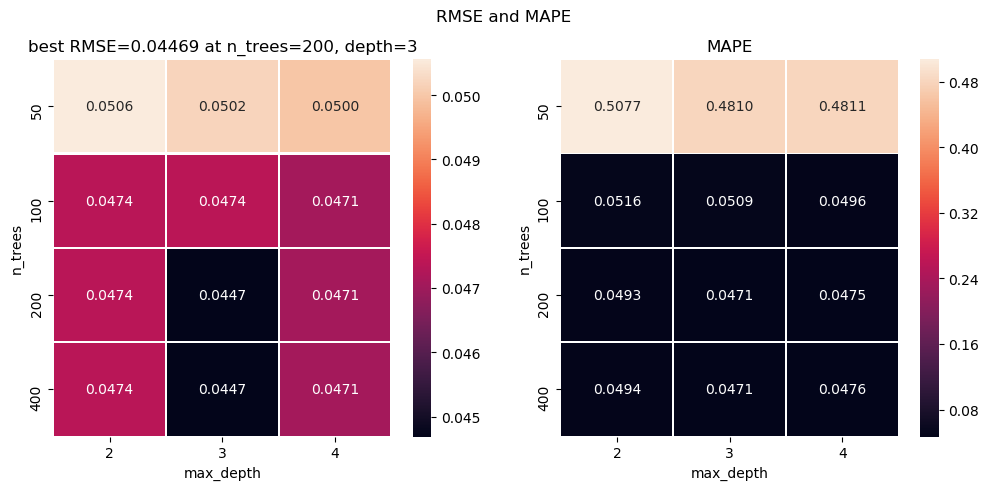

In [33]:
xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=[2, 3, 4], n_trees=[50, 100, 200, 400])


 Training the Model....

 Done... Time taken : 0:00:31.831187

 ---------------------------------------------
    ERROR ON TRAIN DATA 
---------------------------------------------
==> RMSE : 0.0007013816528051316
==> MAPE : 0.00018563910364120074

 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 0.04652782831835677
==> MAPE : 0.04354896352566887

 ---------------------------------------------


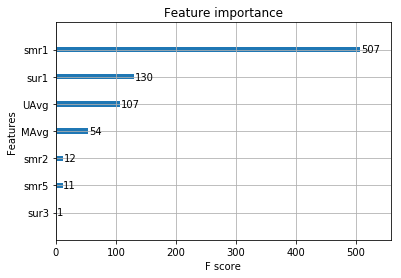

In [26]:
models_evaluation_test['xgb_13f'] = run_xgbr(x_train, y_train, x_test, y_test, max_depth=3, n_trees=200)

__SAMPLE OF PREDICTED RATINGS__

In [27]:
pd.DataFrame(list(zip(models_evaluation_test['xgb_13f']['predictions'],
                      test_features_matrix.rating.values)), columns=['PREDICTED', 'TRUE']).sample(10)

,PREDICTED,TRUE
3512,4.000000,4.0
4881,2.999998,3.0
8166,2.999965,3.0
23368,2.999998,3.0
8715,3.999964,4.0
30130,3.999999,4.0
22109,2.999969,3.0
21169,2.999992,3.0
24188,4.000000,4.0
23086,4.000000,4.0


__OBSERVATIONS__

* Just the first model we built has performed remarkably well.
* It has RMSE=0.046, which is very good.

<h3> 4.4.2 Suprise Baseline Model </h3>

* [2.1 Baseline Estimates](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)

* The above paper says that the predicted rating $\hat{r}_{ui}$ can be decomposed into the linear sum of three parts.

* Then the model becomes a simple linear model.

__Predicted_rating : ( baseline prediction )__

-  [BaselineOnly](http://surprise.readthedocs.io/en/stable/basic_algorithms.html#surprise.prediction_algorithms.baseline_only.BaselineOnly) 
 > <font color='red'>$   \large {\hat{r}_{ui} = b_{ui} =\mu + b_u + b_i} $</font>


- $\pmb \mu $ : Average of all trainings in training data (constant)
- $\pmb b_u$ : User bias (to be found)
- $\pmb b_i$ : Item bias (movie biases) (to be found)


__Optimization function : ( Least Squares Problem )__

* [baselines-estimates-configuration](http://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baselines-estimates-configuration)

> <font color='red'>$ \text {        [mimimize } {b_u, b_i  ]} \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - (\mu + b_u + b_i)\right)^2 +
\lambda \left(b_u^2 + b_i^2 \right)$ </font>

In [28]:
from surprise import BaselineOnly

In [29]:
# options are to specify.., how to compute those user and item biases
bsl_options = {'method' : 'sgd',
               'learning_rate' : 0.005,
               'n_epochs' : 50,
               'reg':0.2}

bsl_algo = BaselineOnly(bsl_options=bsl_options)
# run this algorithm.., It will return the train and test results..
bsl_train_results, bsl_test_results, bsl_cv_results = run_surprise(bsl_algo, Xtrain, Xtest, Xcv)


# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['bsl_algo'] = bsl_train_results
models_evaluation_cv['bsl_algo'] = bsl_cv_results 
models_evaluation_test['bsl_algo'] = bsl_test_results


 Training the MODEL...
Estimating biases using sgd...

 Done... Time taken : 0:00:09.125946

 ---------------------------------------------
    ERROR ON TRAIN DATA
---------------------------------------------
==> RMSE : 0.8977501343653875
==> MAPE : 27.76021788506664


 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.0814854001132115
==> MAPE : 33.84668643931904


 ---------------------------------------------


__OBSERVATIONS__

* Stating that, we've just used a linear model, the performance is awful.
* The predicted value of each rating is just the global_average (GAvg).

<h3> 4.4.3 XGBoost with initial 13 features + Surprise Baseline predictor </h3>

__UPDATING DATA__

In [30]:
# add our baseline_predicted value as our feature..
train_features_matrix['bsl_pred'] = models_evaluation_train['bsl_algo']['predictions']
test_features_matrix['bsl_pred'] = models_evaluation_test['bsl_algo']['predictions']
cv_features_matrix['bsl_pred'] = models_evaluation_cv['bsl_algo']['predictions']

In [31]:
train_features_matrix.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bsl_pred
0,335030,43,3.57743,2.0,2.0,2.0,5.0,2.75,2.0,4.0,3.0,3.0,1.0,4.0604,2.75,2.0,3.436156
1,704642,43,3.57743,2.0,2.0,2.0,5.0,2.75,2.0,3.0,1.0,4.0,4.0,3.4956,2.75,2.0,4.330658


In [32]:
test_features_matrix.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,smr3,smr4,smr5,UAvg,MAvg,rating,bsl_pred
0,1307418,13,3.6698,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0,4.0,3.6000,4.0,4.0,3.57743
1,442370,48,3.6698,4.0,5.0,5.0,4.0,5.0,4.0,5.0,5.0,5.0,4.0,4.1429,4.4,4.0,3.57743


In [33]:
# prepare Train data
x_train = train_features_matrix.drop(['user','movie','rating'], axis=1)
y_train = train_features_matrix['rating']

# Prepare Test data
x_cv = cv_features_matrix.drop(['user','movie','rating'], axis=1)
y_cv = cv_features_matrix['rating']

# Prepare Test data
x_test = test_features_matrix.drop(['user','movie','rating'], axis=1)
y_test = test_features_matrix['rating']

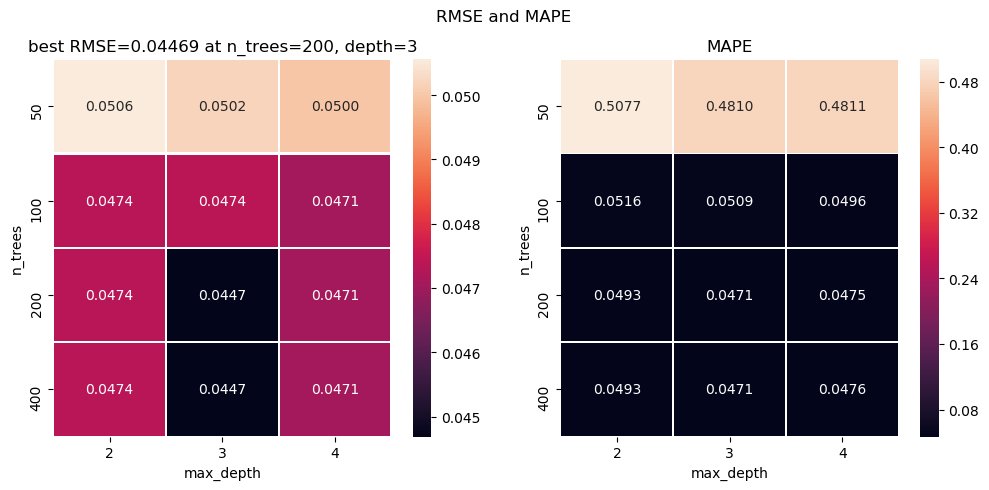

In [131]:
xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=[2, 3, 4], n_trees=[50, 100, 200, 400])


 Training the Model....

 Done... Time taken : 0:00:42.326152

 ---------------------------------------------
    ERROR ON TRAIN DATA 
---------------------------------------------
==> RMSE : 0.0005091955475571123
==> MAPE : 0.0001729512422792165

 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 0.04652995651787225
==> MAPE : 0.043519021198349786

 ---------------------------------------------


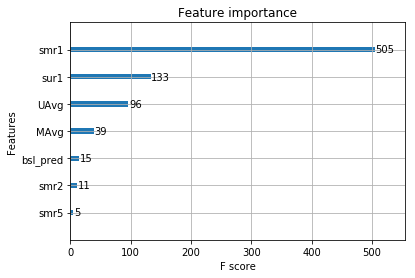

In [34]:
models_evaluation_test['xgb_bsl'] = run_xgbr(x_train, y_train, x_test, y_test, max_depth=3, n_trees=200)

<h3> 4.4.4 Surprise KNNBaseline predictor </h3>

* [KNN BASELINE](http://surprise.readthedocs.io/en/stable/knn_inspired.html#surprise.prediction_algorithms.knns.KNNBaseline )

* [PEARSON_BASELINE SIMILARITY](http://surprise.readthedocs.io/en/stable/similarities.html#surprise.similarities.pearson_baseline )
    
* [SHRINKAGE : 2.2 Neighborhood Models](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)

* __Predicted Rating__ : ( ___based on User-User similarity___ )

\begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)} \end{align}

- $\pmb{b_{ui}}$ -  Baseline prediction of (user,movie) rating
- $ \pmb {N_i^k (u)}$ - Set of __K similar__ users (neighbours) of __user (u)__ who rated __movie(i)__  
- _sim (u, v)_ - __Similarity__ between users __u and v__  
    - Generally, it will be cosine similarity or Pearson correlation coefficient. 
    - But we use __shrunk Pearson-baseline correlation coefficient__, which is based on the pearsonBaseline similarity ( we take base line predictions instead of mean rating of user/item)
       
      

* __Predicted rating__ ( ___based on Item Item similarity___ ):
 \begin{align} \hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{j \in N^k_u(i)}\text{sim}(i, j) \cdot (r_{uj} - b_{uj})} {\sum\limits_{j \in N^k_u(j)} \text{sim}(i, j)} \end{align}

*  _Notations follows same as above (user user based predicted rating )_

In [46]:
from surprise import KNNBaseline
#import pickle

  <h4> 4.4.4.1 Surprise KNNBaseline with user-user similarities</h4>

In [48]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm
sim_options = {'user_based' : True,
               'name': 'pearson_baseline',
               'shrinkage': 80,
               'min_support': 4
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'} 

knn_bsl_user = KNNBaseline(k=20, sim_options = sim_options, bsl_options = bsl_options)
knn_bsl_u_train_results, knn_bsl_u_test_results, knn_bsl_u_cv_results = run_surprise(knn_bsl_user, Xtrain, Xtest, Xcv)


models_evaluation_train['knn_bsl_user'] = knn_bsl_u_train_results
models_evaluation_cv['knn_bsl_user'] = knn_bsl_u_cv_results 
models_evaluation_test['knn_bsl_user'] = knn_bsl_u_test_results


 Training the MODEL...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Done... Time taken : 1:45:05.604756

 ---------------------------------------------
    ERROR ON TRAIN DATA
---------------------------------------------
==> RMSE : 0.3992990938535015
==> MAPE : 11.16042640155627


 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.0821665691002005
==> MAPE : 33.89942904886075


 ---------------------------------------------


<h4> 4.4.4.2 Surprise KNNBaseline with movie movie similarities</h4>

In [37]:
# we specify , how to compute similarities and what to consider with sim_options to our algorithm

# 'user_based' : Fals => this considers the similarities of movies instead of users

sim_options = {'user_based' : False,
               'name': 'pearson_baseline',
               'shrinkage': 100,
               'min_support': 5
              } 
# we keep other parameters like regularization parameter and learning_rate as default values.
bsl_options = {'method': 'sgd'}


knn_bsl_m = KNNBaseline(k=40, sim_options = sim_options, bsl_options = bsl_options, verbose=True)

knn_bsl_m_train_results, knn_bsl_m_test_results, knn_bsl_m_cv_results = run_surprise(knn_bsl_m, Xtrain, Xtest, Xcv)

# Just store these error metrics in our models_evaluation datastructure
#models_evaluation_train['knn_bsl_m'] = knn_bsl_m_train_results 
models_evaluation_train['knn_bsl_movie'] = knn_bsl_m_train_results
models_evaluation_cv['knn_bsl_movie'] = knn_bsl_m_cv_results 
models_evaluation_test['knn_bsl_movie'] = knn_bsl_m_test_results



 Training the MODEL...
Estimating biases using sgd...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

 Done... Time taken : 0:00:18.781476

 ---------------------------------------------
    ERROR ON TRAIN DATA
---------------------------------------------
==> RMSE : 0.49694880275350806
==> MAPE : 13.933879680328747


 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.082961609120101
==> MAPE : 33.921341863785074


 ---------------------------------------------


<h3> 4.4.5 XGBoost with initial 13 features + Surprise Baseline predictor + KNNBaseline predictor </h3>

* First we will run XGBoost with predictions from both KNN's (that uses User_User and Item_Item similarities along with our previous features).

 
* Then we will run XGBoost with just predictions from both knn models and predictions from our baseline model. 

In [49]:
# add our baseline_predicted value as our feature..
train_features_matrix['knn_bsl_movie'] = models_evaluation_train['knn_bsl_movie']['predictions']
test_features_matrix['knn_bsl_movie'] = models_evaluation_test['knn_bsl_movie']['predictions']
cv_features_matrix['knn_bsl_movie'] = models_evaluation_cv['knn_bsl_movie']['predictions']

In [50]:
# add our baseline_predicted value as our feature..
train_features_matrix['knn_bsl_user'] = models_evaluation_train['knn_bsl_user']['predictions']
test_features_matrix['knn_bsl_user'] = models_evaluation_test['knn_bsl_user']['predictions']
cv_features_matrix['knn_bsl_user'] = models_evaluation_cv['knn_bsl_user']['predictions']

In [51]:
# prepare Train data
x_train = train_features_matrix.drop(['user','movie','rating'], axis=1)
y_train = train_features_matrix['rating']

# Prepare Test data
x_test = test_features_matrix.drop(['user','movie','rating'], axis=1)
y_test = test_features_matrix['rating']

# Prepare CV data
x_cv = cv_features_matrix.drop(['user','movie','rating'], axis=1)
y_cv = cv_features_matrix['rating']

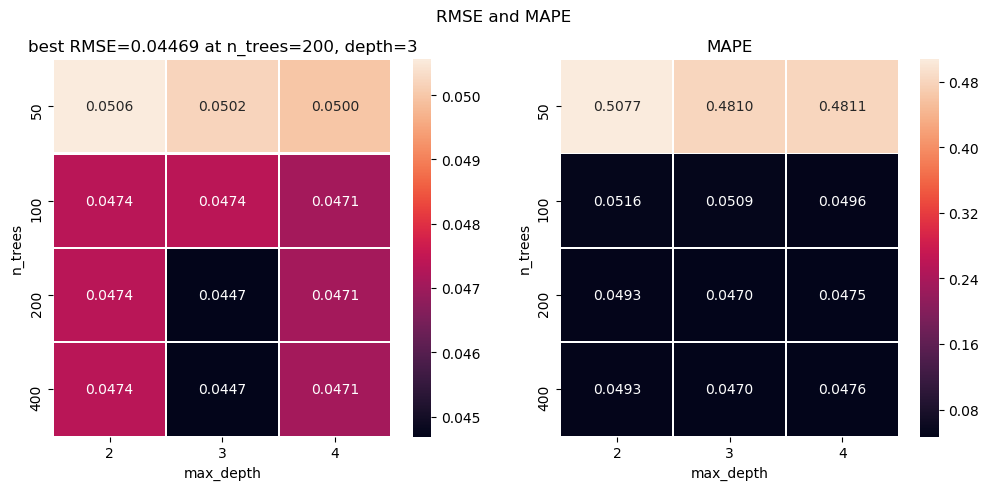

In [53]:
xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=[2, 3, 4], n_trees=[50, 100, 200, 400])


 Training the Model....

 Done... Time taken : 0:00:43.973760

 ---------------------------------------------
    ERROR ON TRAIN DATA 
---------------------------------------------
==> RMSE : 0.0005091955475571123
==> MAPE : 0.0001729512422792165

 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 0.04652995651787225
==> MAPE : 0.043519021198349786

 ---------------------------------------------


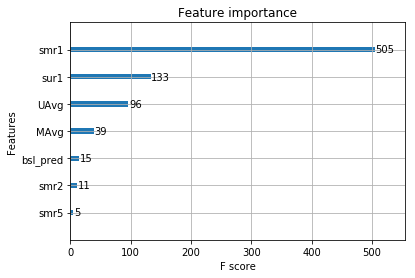

In [54]:
models_evaluation_test['xgb_knn_bsl'] = run_xgbr(x_train, y_train, x_test, y_test, max_depth=3, n_trees=200)

<h3> 4.4.6 Matrix Factorization Techniques </h3>

<h4> 4.4.6.1 SVD Matrix Factorization User Movie intractions </h4>

* [Surprise SVD](http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD )

* __Predicted Rating :__
    - <font color='red'>$ \large  \hat r_{ui} = \mu + b_u + b_i + q_i^Tp_u $</font>
    
        - $\pmb q_i$ - Representation of item(movie) in latent factor space
        
        - $\pmb p_u$ - Representation of user in new latent factor space
    

* [BASIC MATRIX FACTORIZATION MODEL](https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf)

* __Optimization problem with user item interactions and regularization (to avoid overfitting)__
    - <font color='red'>$\large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2\right) $</font>

In [39]:
from surprise import SVD

In [40]:
# initiallize the model
svd = SVD(n_factors=100, biased=True, random_state=15, n_epochs=30)
svd_train_results, svd_test_results, svd_cv_results = run_surprise(svd, Xtrain, Xtest, Xcv)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svd'] = svd_train_results 
models_evaluation_test['svd'] = svd_test_results
models_evaluation_cv['svd'] = svd_cv_results


 Training the MODEL...

 Done... Time taken : 0:01:12.344146

 ---------------------------------------------
    ERROR ON TRAIN DATA
---------------------------------------------
==> RMSE : 0.5430037568556342
==> MAPE : 15.698544815324933


 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.082703202247956
==> MAPE : 33.871274389101316


 ---------------------------------------------


  <h4> 4.4.6.2 SVD Matrix Factorization with implicit feedback from user ( user rated movies ) </h4>

* [2.5 : SVD with Implicit Feedback](http://courses.ischool.berkeley.edu/i290-dm/s11/SECURE/a1-koren.pdf)

* __Predicted Rating :__
    - <font color='red'>$ \large \hat{r}_{ui} = \mu + b_u + b_i + q_i^T\left(p_u +
    |I_u|^{-\frac{1}{2}} \sum_{j \in I_u}y_j\right) $</font> 
    
        - $ \pmb{I_u}$ --- the set of all items rated by user u
        - $\pmb{y_j}$ --- Our new set of item factors that capture implicit ratings.  

* __Optimization problem with user item interactions and regularization (to avoid overfitting)__

    - <font color='red'>$ \large \sum_{r_{ui} \in R_{train}} \left(r_{ui} - \hat{r}_{ui} \right)^2 +
\lambda\left(b_i^2 + b_u^2 + ||q_i||^2 + ||p_u||^2 + ||y_j||^2\right) $ </font>

In [41]:
from surprise import SVDpp

In [43]:
# initiallize the model
svdpp = SVDpp(n_factors=100, random_state=15, verbose=True)
svdpp_train_results, svdpp_test_results, svdpp_cv_results = run_surprise(svdpp, Xtrain, Xtest, Xcv)

# Just store these error metrics in our models_evaluation datastructure
models_evaluation_train['svdpp'] = svdpp_train_results
models_evaluation_cv['svdpp'] = svdpp_cv_results
models_evaluation_test['svdpp'] = svdpp_test_results


 Training the MODEL...
 processing epoch 0
 processing epoch 1
 processing epoch 2
 processing epoch 3
 processing epoch 4
 processing epoch 5
 processing epoch 6
 processing epoch 7
 processing epoch 8
 processing epoch 9
 processing epoch 10
 processing epoch 11
 processing epoch 12
 processing epoch 13
 processing epoch 14
 processing epoch 15
 processing epoch 16
 processing epoch 17
 processing epoch 18
 processing epoch 19

 Done... Time taken : 0:49:11.616042

 ---------------------------------------------
    ERROR ON TRAIN DATA
---------------------------------------------
==> RMSE : 0.57429632267897
==> MAPE : 16.519897534707354


 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.0823897742251258
==> MAPE : 33.871040025290874


 ---------------------------------------------


<h3> 4.4.7 XgBoost with 13 features + Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

__UPDATING DATA__

In [58]:
# add our baseline_predicted value as our feature..
train_features_matrix['svd_pred'] = models_evaluation_train['svd']['predictions']
test_features_matrix['svd_pred'] = models_evaluation_test['svd']['predictions']
cv_features_matrix['svd_pred'] = models_evaluation_cv['svd']['predictions']

In [59]:
# add our baseline_predicted value as our feature..
train_features_matrix['svdpp_pred'] = models_evaluation_train['svdpp']['predictions']
test_features_matrix['svdpp_pred'] = models_evaluation_test['svdpp']['predictions']
cv_features_matrix['svdpp_pred'] = models_evaluation_cv['svdpp']['predictions']

In [60]:
train_features_matrix.head(2)

,user,movie,GAvg,sur1,sur2,sur3,sur4,sur5,smr1,smr2,...,smr4,smr5,UAvg,MAvg,rating,bsl_pred,knn_bsl_movie,knn_bsl_user,svd_pred,svdpp_pred
0,335030,43,3.57743,2.0,2.0,2.0,5.0,2.75,2.0,4.0,...,3.0,1.0,4.0604,2.75,2.0,3.436156,2.000000,2.140806,2.708405,2.769889
1,704642,43,3.57743,2.0,2.0,2.0,5.0,2.75,2.0,3.0,...,4.0,4.0,3.4956,2.75,2.0,4.330658,4.902851,4.845939,4.662842,4.566737


In [61]:
# prepare Train data
x_train = train_features_matrix.drop(['user','movie','rating'], axis=1)
y_train = train_features_matrix['rating']

# Prepare Test data
x_test = test_features_matrix.drop(['user','movie','rating'], axis=1)
y_test = test_features_matrix['rating']

# Prepare CV data
x_cv = cv_features_matrix.drop(['user','movie','rating'], axis=1)
y_cv = cv_features_matrix['rating']

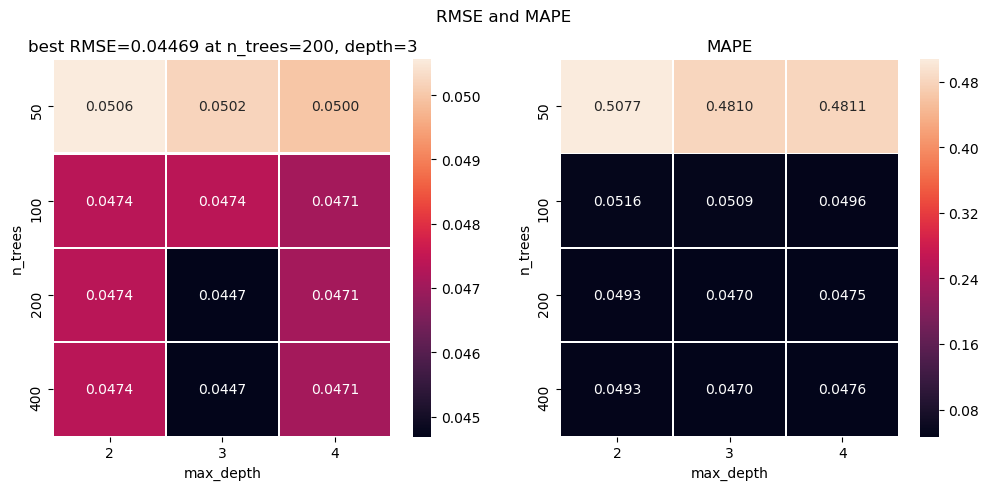

In [62]:
xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=[2, 3, 4], n_trees=[50, 100, 200, 400])


 Training the Model....

 Done... Time taken : 0:01:12.124753

 ---------------------------------------------
    ERROR ON TRAIN DATA 
---------------------------------------------
==> RMSE : 0.0005091955475571123
==> MAPE : 0.0001729512422792165

 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 0.04652995651787225
==> MAPE : 0.043519021198349786

 ---------------------------------------------


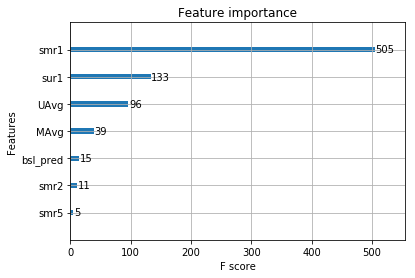

In [63]:
models_evaluation_test['xgb_final'] = run_xgbr(x_train, y_train, x_test, y_test, max_depth=3, n_trees=200)

<h3> 4.4.8 XgBoost with Surprise Baseline + Surprise KNNbaseline + MF Techniques </h3>

In [64]:
# prepare train data
x_train = train_features_matrix[['knn_bsl_user', 'knn_bsl_movie', 'svd_pred', 'svdpp_pred']]
y_train = train_features_matrix['rating']

# test data
x_test = test_features_matrix[['knn_bsl_user', 'knn_bsl_movie', 'svd_pred', 'svdpp_pred']]
y_test = test_features_matrix['rating']

# cv data
x_cv = cv_features_matrix[['knn_bsl_user', 'knn_bsl_movie', 'svd_pred', 'svdpp_pred']]
y_cv = cv_features_matrix['rating']

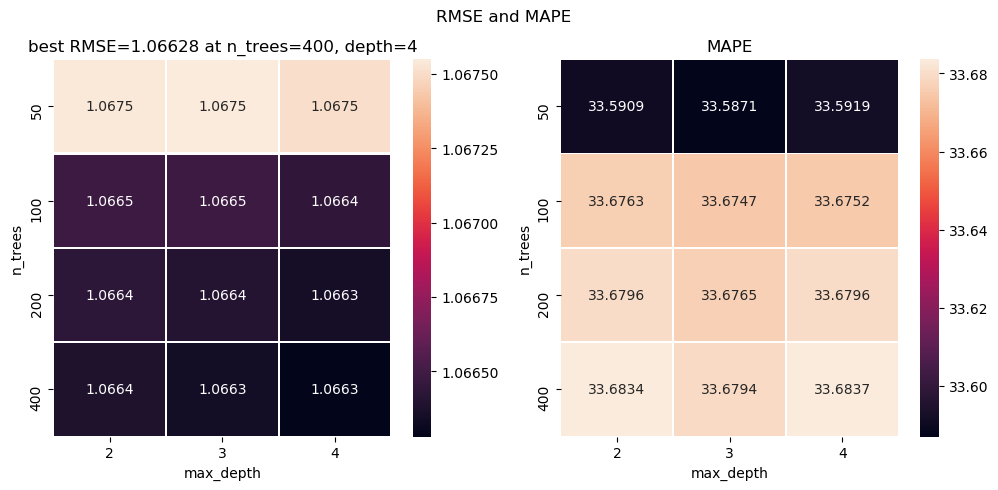

In [65]:
xgboost_cv(x_train, y_train, x_cv, y_cv, depth_vals=[2, 3, 4], n_trees=[50, 100, 200, 400])


 Training the Model....

 Done... Time taken : 0:01:32.948371

 ---------------------------------------------
    ERROR ON TRAIN DATA 
---------------------------------------------
==> RMSE : 1.0756636625272098
==> MAPE : 35.343392804381565

 ---------------------------------------------
    ERROR ON TEST DATA
---------------------------------------------
==> RMSE : 1.0891805123744445
==> MAPE : 34.32695975890435

 ---------------------------------------------


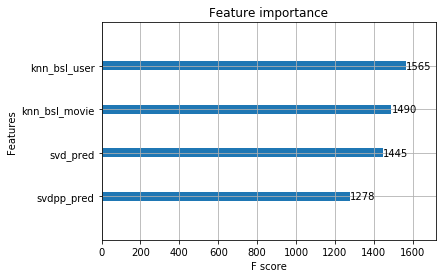

In [66]:
models_evaluation_test['xgb_all_models'] = run_xgbr(x_train, y_train, x_test, y_test, max_depth=4, n_trees=400)

<h2> 4.5 Comparision between all models </h2>

In [69]:
# Saving our TEST_RESULTS into a dataframe so that you don't have to run it again
pd.DataFrame(models_evaluation_test).to_csv('small_sample_results.csv')
models = pd.read_csv('small_sample_results.csv', index_col=0)

In [108]:
pd.DataFrame(models.loc['rmse'].sort_values())

,rmse
xgb_13f,0.04652782831835677
xgb_bsl,0.04652995651787225
xgb_knn_bsl,0.04652995651787225
xgb_final,0.04652995651787225
bsl_algo,1.0814854001132115
knn_bsl_user,1.0821665691002005
svdpp,1.0823897742251258
svd,1.082703202247956
knn_bsl_movie,1.082961609120101
xgb_all_models,1.0891805123744445


In [121]:
pd.DataFrame(list(zip_longest(y_test,\
                              models_evaluation_test['xgb_13f']['predictions'],\
                              models_evaluation_test['xgb_all_models']['predictions'],\
                              models_evaluation_test['svd']['predictions'],\
                              models_evaluation_test['svdpp']['predictions'])),\
             columns=['TRUE', 'xgb_13f_pred', 'xgb_all_models_pred', 'svd_pred', 'svdpp_pred']).sample(10)

,TRUE,xgb_13f_pred,xgb_all_models_pred,svd_pred,svdpp_pred
30535,4.0,4.000000,3.584542,3.577430,3.577430
23615,3.0,2.999999,3.584542,3.577430,3.577430
20935,5.0,4.999998,3.581991,4.082744,4.001245
23350,1.0,1.000001,3.584542,3.577430,3.577430
13846,4.0,4.000000,3.584542,3.577430,3.577430
11239,5.0,4.999994,3.584542,3.577430,3.577430
29608,1.0,1.000002,3.584542,3.577430,3.577430
18778,3.0,3.000478,3.584542,3.577430,3.577430
12852,5.0,4.999998,3.584542,3.577430,3.577430
28191,4.0,4.000000,3.584542,3.577430,3.577430


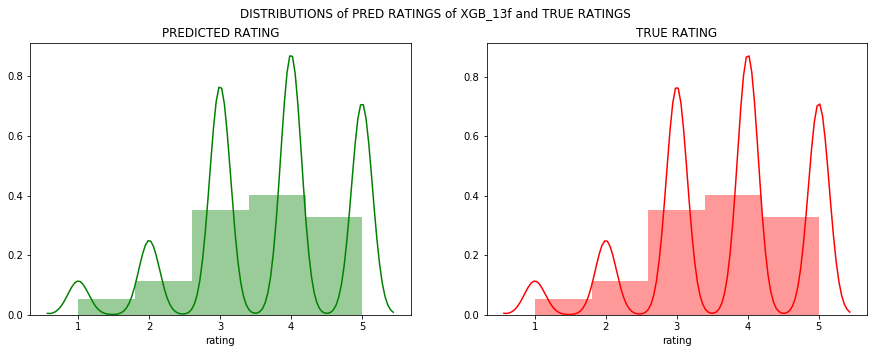

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('DISTRIBUTIONS of PRED RATINGS of XGB_13f and TRUE RATINGS')
sns.distplot(models_evaluation_test['xgb_13f']['predictions'], bins=5, ax=ax1, color='g')
ax1.set_title('PREDICTED RATING')
ax1.set_xlabel('rating')
sns.distplot(y_test.values, bins=5, ax=ax2, color='r')
ax2.set_title('TRUE RATING')
ax2.set_xlabel('rating')
plt.show()

> * Both the distributions look exactly similar, the first model(xgb_13f) we built has performed very well.

> 

# 5. Conclusion

* We built 11 models on the sampled train data.

* The 13 handcrafted features combined with XGBoost resulted in a terrific model with RMSE=0.0465.

* Similar_User1 and Similar_Movie1 seem to have great impact on the model's outcome.

* All the models except for XGBoost had higher RMSE values. They failed to perform.<br>
Most of the predicted ratings by these models is just the Global Average.
